In [31]:
from fractions import Fraction
from collections import namedtuple
from numbers import Number

import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

Приведение матрицы к ступенчатому виду методом Гаусса. Предполагается, что элементы имеют тип <code>fractions.Fraction</code>.

In [2]:
Swap = namedtuple('Swap', ['swap_type', 'first', 'second'])
RowAddition = namedtuple('RowAddition', ['source', 'target', 'coefficient'])
MaxValueWithPlace = namedtuple('MaxValueWithPlace', ['place', 'value'])


def check_equation(matrix, free_column):
    if not isinstance(matrix, list):
        raise TypeError("matrix must be 'list' of 'list's of 'Fraction's")
    if len(matrix) == 0:
        raise ValueError('empty matrix')
    for line in matrix:
        if not isinstance(line, list):
            raise TypeError("matrix must be 'list' of 'list's of 'Fraction's")
        if not all(map(lambda x: isinstance(x, Fraction), line)):
            raise TypeError("matrix must be 'list' of 'list's of 'Fraction's")
    row_len = len(matrix[0])
    if row_len == 0 or any(map(lambda x: len(x) != row_len, matrix)):
        raise ValueError('all rows must have constant non-zero length')

    if not isinstance(free_column, list):
        raise TypeError("free column must be 'list' of 'Fraction's")
    if len(matrix) != len(free_column):
        raise ValueError("heights of matrix and free column must be equal")
    if not all(map(lambda x: isinstance(x, Fraction), free_column)):
        raise TypeError("free column must be 'list' of 'Fraction's")


def swap_rows(m, i, j):
    m[i], m[j] = m[j], m[i]


def swap_columns(m, i, j):
    for row in m:
        row[i], row[j] = row[j], row[i]


def add_row(matrix, source, target, coefficient):
    for i in range(len(matrix[0])):
        matrix[target][i] += coefficient * matrix[source][i]


def find_max(m, start):
    res = MaxValueWithPlace(place=(start, start), value=abs(m[start][start]))
    for i in range(start, len(m)):
        for j in range(start, len(m[i])):
            current_value = abs(m[i][j])
            if current_value > res.value:
                res = MaxValueWithPlace(place=(i, j), value=current_value)
    return res


def to_row_echelon_form(m):
    actions = []
    for i in range(min(len(m), len(m[0]))):
        max_elem = find_max(m, i)
        max_row, max_column = max_elem.place

        if max_elem.value == 0:
            return actions

        if max_row != i:
            actions.append(Swap(swap_type='row', first=i,
                                second=max_row))
            swap_rows(m, i, max_row)

        if max_column != i:
            actions.append(Swap(swap_type='column', first=i,
                                second=max_column))
            swap_columns(m, i, max_column)

        for row in range(i + 1, len(m)):
            if m[row][i] == 0:
                continue
            coef = -m[row][i] / m[i][i]
            actions.append(RowAddition(source=i, target=row, coefficient=coef))
            add_row(m, i, row, coef)

    return actions


def apply_actions_to_column(column, actions):
    for action in actions:
        if isinstance(action, Swap) and action.swap_type == 'row':
            column[action.first], column[action.second] = \
                column[action.second], column[action.first]
        elif isinstance(action, RowAddition):
            column[action.target] += action.coefficient * column[action.source]


def solve(matrix, free_column):
    check_equation(matrix, free_column)
    actions = to_row_echelon_form(matrix)
    apply_actions_to_column(free_column, actions)

    col_num = len(matrix[0])
    row_num = len(matrix)
    solution = [None] * col_num
    for row in range(row_num - 1, -1, -1):
        new_vars = 0
        left_sum = Fraction(0)
        new_var_pos = col_num
        for column in range(col_num):
            if matrix[row][column] != 0:
                if solution[column] is None:
                    new_vars += 1
                    new_var_pos = min(column, new_var_pos)
                else:
                    left_sum += solution[column] * matrix[row][column]

        if new_vars == 0 and left_sum != free_column[row]:
            raise ValueError('the equation has no solution')
        elif new_vars == 1:
            solution[new_var_pos] = (free_column[row] - left_sum) / matrix[row][
                new_var_pos]
        elif new_vars > 1:
            solution[new_var_pos] = []
            for column in range(col_num):
                if column == new_var_pos:
                    solution[new_var_pos].append(Fraction(0))
                    continue

                if matrix[row][column] != 0 and solution[column] is None:
                    solution[new_var_pos].append(
                        -matrix[row][column] / matrix[row][new_var_pos])
                else:
                    solution[new_var_pos].append(Fraction(0))
            solution[new_var_pos].append(
                (free_column[row] - left_sum) / matrix[row][new_var_pos])

    for action in reversed(actions):
        if isinstance(action, Swap) and action.swap_type == 'column':
            solution[action.first], solution[action.second] = \
                solution[action.second], solution[action.first]
    return solution


Используемые значения

In [3]:
x = [i / 8 for i in range(9)]
y = [0., 0.021470, 0.293050, 0.494105, 0.541341, 0.516855, 0.468617, 0.416531, 0.367879]
print(x)
print(y)

[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
[0.0, 0.02147, 0.29305, 0.494105, 0.541341, 0.516855, 0.468617, 0.416531, 0.367879]


Значения для первых частей задания

In [4]:
x_s = x[::2]
y_s = y[::2]
print(x_s, y_s)

[0.0, 0.25, 0.5, 0.75, 1.0] [0.0, 0.29305, 0.541341, 0.468617, 0.367879]


# Часть 1
Найти $f'\left( x_3 \right)$ методом неопределённых коэффициентов

In [5]:
x_vals = list(map(Fraction, x_s))
x_vals

[Fraction(0, 1),
 Fraction(1, 4),
 Fraction(1, 2),
 Fraction(3, 4),
 Fraction(1, 1)]

In [6]:
x_0 = Fraction(x[2])
x_0

Fraction(1, 4)

Разложение по формуле Тейлора: $f \left( x \right) = f \left( x_0 \right) + f' \left( x_0 \right) \left( x-x_0 \right) + \frac{f'' \left( x_0 \right)}{2} {\left( x-x_0 \right)}^2 + \dots + \frac{f^{\left( n \right)} \left( x_0 \right)}{n!} {\left( x-x_0 \right)}^n + \frac{f^{\left( n+1 \right)} \left( \xi \right)}{\left( n+1 \right)!} {\left( x-x_0 \right)}^{n+1}$

In [7]:
def get_taylor_coefficients(x, x0, num):
    delta = x - x0
    coeff = [Fraction(1)]
    for i in range(1, num):
        coeff.append(coeff[-1] * delta / i)
    return coeff


In [8]:
taylor = [get_taylor_coefficients(x, x_0, len(x_vals) + 1) for x in x_vals]
taylor

[[Fraction(1, 1),
  Fraction(-1, 4),
  Fraction(1, 32),
  Fraction(-1, 384),
  Fraction(1, 6144),
  Fraction(-1, 122880)],
 [Fraction(1, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1)],
 [Fraction(1, 1),
  Fraction(1, 4),
  Fraction(1, 32),
  Fraction(1, 384),
  Fraction(1, 6144),
  Fraction(1, 122880)],
 [Fraction(1, 1),
  Fraction(1, 2),
  Fraction(1, 8),
  Fraction(1, 48),
  Fraction(1, 384),
  Fraction(1, 3840)],
 [Fraction(1, 1),
  Fraction(3, 4),
  Fraction(9, 32),
  Fraction(9, 128),
  Fraction(27, 2048),
  Fraction(81, 40960)]]

In [9]:
matrix = []
for i in range(1, len(x_vals)):
    matrix.append([])
    for j in range(len(x_vals)):
        if x_vals[j] == x_0:
            continue
        matrix[-1].append(taylor[j][i])
matrix

[[Fraction(-1, 4), Fraction(1, 4), Fraction(1, 2), Fraction(3, 4)],
 [Fraction(1, 32), Fraction(1, 32), Fraction(1, 8), Fraction(9, 32)],
 [Fraction(-1, 384), Fraction(1, 384), Fraction(1, 48), Fraction(9, 128)],
 [Fraction(1, 6144), Fraction(1, 6144), Fraction(1, 384), Fraction(27, 2048)]]

In [10]:
column = [Fraction(0)] * (len(x_vals) - 1)
column[0] = Fraction(1)
column

[Fraction(1, 1), Fraction(0, 1), Fraction(0, 1), Fraction(0, 1)]

In [11]:
coefs = solve(matrix, column)
coefs

[Fraction(-1, 1), Fraction(6, 1), Fraction(-2, 1), Fraction(1, 3)]

In [12]:
it = iter(coefs)
coefs = [next(it) if x_vals[i] != x_0 else -sum(coefs) for i in range(len(x_vals))]
coefs

[Fraction(-1, 1),
 Fraction(-10, 3),
 Fraction(6, 1),
 Fraction(-2, 1),
 Fraction(1, 3)]

In [13]:
print(*['({})*f(x_{})'.format(coefs[i], i + 1) for i in range(len(coefs))], sep=' + ')

(-1)*f(x_1) + (-10/3)*f(x_2) + (6)*f(x_3) + (-2)*f(x_4) + (1/3)*f(x_5)


Итак, мы получили следующую приближённую формулу: $f' \left( x_2 \right) \approx -f \left( x_1 \right) - \frac{10}{3} f \left( x_2 \right) + 6 f \left( x_3 \right) - 2 f \left( x_4 \right) + \frac{1}{3} f \left( x_5 \right)$

Тогда вычислим значение $f' \left( x_2 \right)$ (или $f' \left( x_3 \right)$ в изначальных обозначениях)

In [14]:
value = sum(map(lambda x, y: x * y, coefs, y_s))
print(f'{value:.6}')

1.4566


In [15]:
sum(map(lambda a, x: a[-1] * x, taylor, coefs))

Fraction(1, 5120)

In [16]:
sum(map(lambda a, x: abs(a[-1] * x), taylor, coefs))

Fraction(19, 15360)

# Часть 2
Найти $f \left( x_2 \right)$ при помощи интерполяционного многочлена

In [17]:
def poly_to_str(p):
    return ' + '.join(['({})*x^({})'.format(p[i], i) if i > 0 else '({})'.format(p[i]) for i in range(len(p))])

In [18]:
def poly_eval(p, x):
    res = 0
    deg = 1
    for c in p:
        res += c * deg
        deg *= x
    return res

In [19]:
def poly_sum(p, *args):
    if len(args) == 0:
        return p
    
    q = args[0] if len(args) == 1 else poly_sum(*args)
    if len(p) < len(q):
        p, q = q, p
        
    r = []
    for i in range(len(q)):
        r.append(p[i] + q[i])
        
    r.extend(p[len(q):])
    while len(r) > 1 and r[-1] == 0:
        del r[-1]
    return r
    


def poly_prod(p, *args):
    if len(args) == 0:
        return p
    
    q = args[0] if len(args) == 1 else poly_prod(*args)
    r = []
    for i in range(len(p) + len(q)):
        r.append(0)
        for pd in range(i + 1):
            qd = i - pd
            if pd < len(p) and qd < len(q):
                r[-1] += p[pd] * q[qd]
    while len(r) > 1 and r[-1] == 0:
        del r[-1]
    return r

In [20]:
def splitted_diffs(x, y):
    diffs = [y[:]]
    for d in range(1, len(x)):
        diffs.append([])
        for n in range(len(x) - d):
            new_diff = (diffs[d - 1][n + 1] - diffs[d - 1][n]) / (x[n + d] - x[n])
            diffs[-1].append(new_diff)
    return diffs

In [21]:
def newton_interpolation(x, y):
    diffs = splitted_diffs(x, y)
    s = []
    for i in range(len(x)):
        s.append(poly_prod([diffs[i][0]], *[[-x[j], 1] for j in range(i)]))
    return poly_sum(*s)

In [22]:
inter_poly = newton_interpolation(x_s, y_s)
print(poly_to_str(inter_poly))

(0.0) + (0.3241196666666668)*x^(1) + (6.026527333333331)*x^(2) + (-12.054842666666662)*x^(3) + (6.072074666666665)*x^(4)


In [23]:
y_s, list(map(lambda x: poly_eval(inter_poly, x), x_s))

([0.0, 0.29305, 0.541341, 0.468617, 0.367879],
 [0.0, 0.29305, 0.5413410000000001, 0.4686170000000005, 0.3678790000000012])

In [29]:
poly_eval(inter_poly, x[1]), y[1]

(0.11261727343749998, 0.02147)

<IPython.core.display.Javascript object>


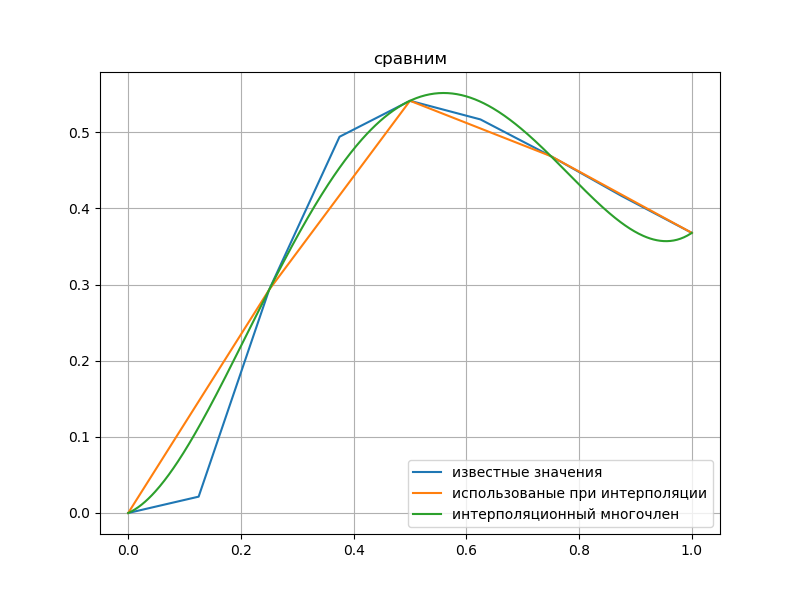

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='известные значения')
plt.plot(x_s, y_s, label='использованые при интерполяции')
xs = np.linspace(x[0], x[-1], 500)
ys = np.array([poly_eval(inter_poly, x) for x in xs])
plt.plot(xs, ys, label='интерполяционный многочлен')
plt.legend()
plt.grid()
plt.show()